In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The texts were converted to lower case, and all punctuation marks were removed.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out as test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.str.split().tolist()
X_test = titles_test.title.str.split().tolist()

y_train = titles_train.category.values
y_test = titles_test.category.values

Categorical labels were converted to one-hot vector representations.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

The continuous bag-of-words model was used to generate Word2vec embeddings. The continuous bag-of-words method trains a network that can predict the target word given the contextual words around it in the corpus. Word2vec project each word into a high-dimension vector space where contextually close words are located spatially closely.

Here, individual words, which appeared more than (including) twice in the data in the training set, were mapped to 128-dimension vectors, while the algorithm utilized the 8 words around it in the text as the context. We then coverted the titles in both the training and test sets to sequences of vectors where each vector represents a word. Novel words that were not included in the vocabulary during training were mapped to a vector with all elements equal to 0.

As the titles were not of equal length, padding was needed. All titles were pre-padded with vectors where all elements are set to 0 so they all have the same length in the final vector-sequence representations.

In [6]:
from itertools import chain

def extractVocabulary(titles, min_count):
    
    flatten_titles = list(chain(*titles))
    
    vocabulary, counts = np.unique(flatten_titles, return_counts=True)
    vocabulary = vocabulary[counts >= 2]
    
    return vocabulary

In [7]:
from gensim.sklearn_api import W2VTransformer

vectorLength = 512
vectorizer = W2VTransformer(size=vectorLength, window=3, min_count=2, null_word=1, workers=-2, iter=2500)
vectorizer.fit(X_train)
vocabulary = extractVocabulary(X_train, 2)

In [8]:
def mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength):
    
    vectorsMatrix = np.zeros((maxLength, vectorSize))
    nWords = len(title)
    prePadLength = maxLength - nWords
    for i, word in enumerate(title):
        if word in vocabulary:
            vectorsMatrix[prePadLength + i, :] = vectorizer.transform(word)
            
    return vectorsMatrix

In [9]:
from multiprocessing import Pool
from multiprocessing import cpu_count
from functools import partial

def mapTitles2Vectors(titles, vectorizer, vocabulary, vectorSize, maxLength):
    
    pool = Pool(cpu_count() - 1)
    
#     nTitles = len(titles)
    
#     representations = [[] for i in range(nTitles)]
#     for i, title in tqdm(enumerate(titles)):
#         representations[i] = mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength)
    
    mapTitle2Vectors_partial = partial(mapTitle2Vectors, vectorizer=vectorizer, vocabulary=vocabulary, vectorSize=vectorSize, maxLength=maxLength)
    representations = pool.map(mapTitle2Vectors_partial, titles)
    
    return np.concatenate(list(map(lambda mat: mat[np.newaxis, :], representations)), axis=0)

In [10]:
maxTitleLength = max(map(len, X_train + X_test))
vectors_train = mapTitles2Vectors(X_train, vectorizer, vocabulary, vectorLength, maxTitleLength)
vectors_test = mapTitles2Vectors(X_test, vectorizer, vocabulary, vectorLength, maxTitleLength)

# LSTM neural network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from time import time

lstmLayer = LSTM(512, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(512, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier = Sequential([lstmLayer, fullyConnectedLayer1, fullyConnectedLayer2])
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=2)
best_model_saving = ModelCheckpoint("new_LSTM_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=2)

start_time = time()
history = classifier.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier = load_model("new_LSTM_best_model.h5")

_, train_accuracy = classifier.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 277s - loss: 4.2442 - acc: 0.0378 - val_loss: 4.1586 - val_acc: 0.0400

Epoch 00001: val_acc improved from -inf to 0.03999, saving model to new_LSTM_best_model.h5
Epoch 2/5000
 - 276s - loss: 4.1593 - acc: 0.0397 - val_loss: 4.1581 - val_acc: 0.0400

Epoch 00002: val_acc did not improve from 0.03999
Epoch 3/5000
 - 268s - loss: 4.1587 - acc: 0.0398 - val_loss: 4.1588 - val_acc: 0.0400

Epoch 00003: val_acc did not improve from 0.03999
Epoch 4/5000
 - 264s - loss: 4.1584 - acc: 0.0395 - val_loss: 4.1582 - val_acc: 0.0378

Epoch 00004: val_acc did not improve from 0.03999
Epoch 5/5000
 - 267s - loss: 4.1580 - acc: 0.0396 - val_loss: 4.1573 - val_acc: 0.0401

Epoch 00005: val_acc improved from 0.03999 to 0.04010, saving model to new_LSTM_best_model.h5
Epoch 6/5000
 - 268s - loss: 4.1575 - acc: 0.0398 - va


Epoch 00045: val_acc improved from 0.18035 to 0.18185, saving model to new_LSTM_best_model.h5
Epoch 46/5000
 - 266s - loss: 3.3234 - acc: 0.1933 - val_loss: 3.3875 - val_acc: 0.1827

Epoch 00046: val_acc improved from 0.18185 to 0.18268, saving model to new_LSTM_best_model.h5
Epoch 47/5000
 - 267s - loss: 3.3120 - acc: 0.1952 - val_loss: 3.3639 - val_acc: 0.1893

Epoch 00047: val_acc improved from 0.18268 to 0.18929, saving model to new_LSTM_best_model.h5
Epoch 48/5000
 - 266s - loss: 3.2938 - acc: 0.1984 - val_loss: 3.3763 - val_acc: 0.1886

Epoch 00048: val_acc did not improve from 0.18929
Epoch 49/5000
 - 268s - loss: 3.3196 - acc: 0.1940 - val_loss: 3.3778 - val_acc: 0.1836

Epoch 00049: val_acc did not improve from 0.18929
Epoch 50/5000
 - 267s - loss: 3.2863 - acc: 0.2011 - val_loss: 3.3506 - val_acc: 0.1937

Epoch 00050: val_acc improved from 0.18929 to 0.19372, saving model to new_LSTM_best_model.h5
Epoch 51/5000
 - 268s - loss: 3.2612 - acc: 0.2058 - val_loss: 3.3391 - val_ac

 - 266s - loss: 2.7207 - acc: 0.3156 - val_loss: 3.0946 - val_acc: 0.2632

Epoch 00095: val_acc improved from 0.26187 to 0.26321, saving model to new_LSTM_best_model.h5
Epoch 96/5000
 - 264s - loss: 2.7096 - acc: 0.3192 - val_loss: 3.1450 - val_acc: 0.2603

Epoch 00096: val_acc did not improve from 0.26321
Epoch 97/5000
 - 267s - loss: 2.7189 - acc: 0.3166 - val_loss: 3.0457 - val_acc: 0.2680

Epoch 00097: val_acc improved from 0.26321 to 0.26804, saving model to new_LSTM_best_model.h5
Epoch 98/5000
 - 271s - loss: 2.6936 - acc: 0.3222 - val_loss: 3.0718 - val_acc: 0.2646

Epoch 00098: val_acc did not improve from 0.26804
Epoch 99/5000
 - 268s - loss: 2.6805 - acc: 0.3239 - val_loss: 3.0602 - val_acc: 0.2688

Epoch 00099: val_acc improved from 0.26804 to 0.26879, saving model to new_LSTM_best_model.h5
Epoch 100/5000
 - 271s - loss: 2.6755 - acc: 0.3250 - val_loss: 3.1297 - val_acc: 0.2662

Epoch 00100: val_acc did not improve from 0.26879
Epoch 101/5000
 - 265s - loss: 2.6695 - acc: 0.

 - 263s - loss: 2.2481 - acc: 0.4136 - val_loss: 3.1217 - val_acc: 0.2856

Epoch 00150: val_acc did not improve from 0.28773
Epoch 151/5000
 - 271s - loss: 2.2612 - acc: 0.4102 - val_loss: 3.2465 - val_acc: 0.2830

Epoch 00151: val_acc did not improve from 0.28773
Epoch 152/5000
 - 263s - loss: 2.2574 - acc: 0.4103 - val_loss: 3.3415 - val_acc: 0.2769

Epoch 00152: val_acc did not improve from 0.28773
Epoch 153/5000
 - 266s - loss: 2.2330 - acc: 0.4164 - val_loss: 3.2983 - val_acc: 0.2788

Epoch 00153: val_acc did not improve from 0.28773
Epoch 154/5000
 - 267s - loss: 2.2369 - acc: 0.4156 - val_loss: 3.2462 - val_acc: 0.2816

Epoch 00154: val_acc did not improve from 0.28773
Epoch 155/5000
 - 264s - loss: 2.2322 - acc: 0.4163 - val_loss: 3.2410 - val_acc: 0.2844

Epoch 00155: val_acc did not improve from 0.28773
Epoch 156/5000
 - 265s - loss: 2.2021 - acc: 0.4237 - val_loss: 3.1765 - val_acc: 0.2869

Epoch 00156: val_acc did not improve from 0.28773
Epoch 157/5000
 - 268s - loss: 2.24


Epoch 00208: val_acc did not improve from 0.28840
Epoch 209/5000
 - 287s - loss: 1.9402 - acc: 0.4797 - val_loss: 3.5619 - val_acc: 0.2784

Epoch 00209: val_acc did not improve from 0.28840
Epoch 210/5000
 - 279s - loss: 1.9056 - acc: 0.4905 - val_loss: 3.5310 - val_acc: 0.2827

Epoch 00210: val_acc did not improve from 0.28840
Epoch 211/5000
 - 279s - loss: 1.9062 - acc: 0.4903 - val_loss: 3.6139 - val_acc: 0.2816

Epoch 00211: val_acc did not improve from 0.28840
Epoch 212/5000
 - 282s - loss: 1.9193 - acc: 0.4868 - val_loss: 3.6768 - val_acc: 0.2752

Epoch 00212: val_acc did not improve from 0.28840
Epoch 213/5000
 - 309s - loss: 1.9021 - acc: 0.4905 - val_loss: 3.6994 - val_acc: 0.2779

Epoch 00213: val_acc did not improve from 0.28840
Epoch 214/5000
 - 325s - loss: 1.9501 - acc: 0.4778 - val_loss: 3.4482 - val_acc: 0.2811

Epoch 00214: val_acc did not improve from 0.28840
Epoch 215/5000
 - 286s - loss: 1.9032 - acc: 0.4894 - val_loss: 3.5517 - val_acc: 0.2835

Epoch 00215: val_ac

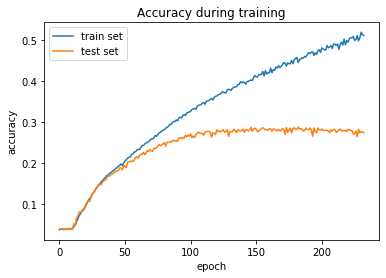

In [12]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Precision-recall

In [13]:
probability = classifier.predict_proba(vectors_test)
classList = integer_encoder.classes_

In [14]:
realLabel = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classList), axis=1), np.repeat(np.reshape(classList, (1, -1)), len(y_test), axis=0))
thresholds = np.arange(0, 1.001, 0.001)
precision = np.zeros((len(thresholds), len(classList)))
recall = np.zeros((len(thresholds), len(classList)))

for i, threshold in enumerate(thresholds):
    predictedLabel = probability >= threshold

    truePoz = (predictedLabel & realLabel).sum(axis = 0)
    falsePoz = (predictedLabel & (realLabel == False)).sum(axis = 0)
    falseNeg = ((predictedLabel == False) & realLabel).sum(axis = 0)

    precision[i, :] = truePoz / (truePoz + falsePoz)
    recall[i, :] = truePoz / (truePoz + falseNeg)
    
averagePrecision = np.nanmean(precision, axis=1)
averageRecall = np.nanmean(recall, axis=1)
minPrecision = np.nanmin(precision, axis=1)
maxPrecision = np.nanmax(precision, axis=1)

Text(0, 0.5, 'precision')

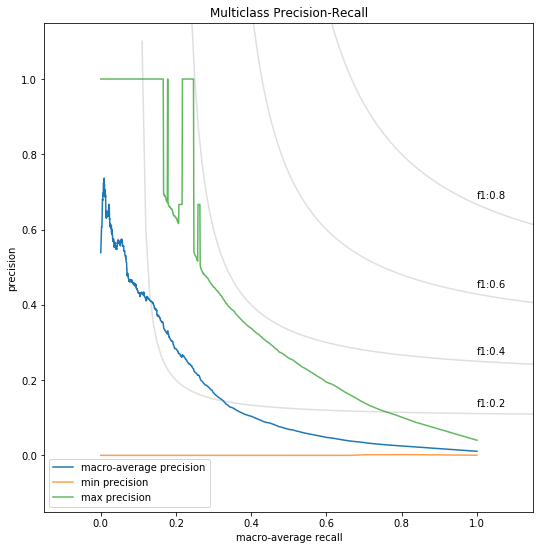

In [15]:
plt.figure(figsize=(9,9))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1.15, 115)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.25)
    plt.annotate('f1:{0:0.1f}'.format(f_score), xy=(1, y[100] + 0.02))

plt.plot(averageRecall, averagePrecision, label="macro-average precision")
plt.plot(averageRecall, minPrecision, label="min precision", alpha=0.75)
plt.plot(averageRecall, maxPrecision, label="max precision", alpha=0.75)

plt.xlim([-.15, 1.15])
plt.ylim([-.15, 1.15])
plt.gca().set_aspect('equal')
plt.legend(loc="lower left")
plt.title("Multiclass Precision-Recall")
plt.xlabel("macro-average recall")
plt.ylabel("precision")

In [16]:
maxProbability = probability.max(axis=1)
classifiedProportion = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    classifiedProportion[i] = (maxProbability >= threshold).sum() / len(maxProbability)

Text(0.5, 1.0, 'Precision & Recall')

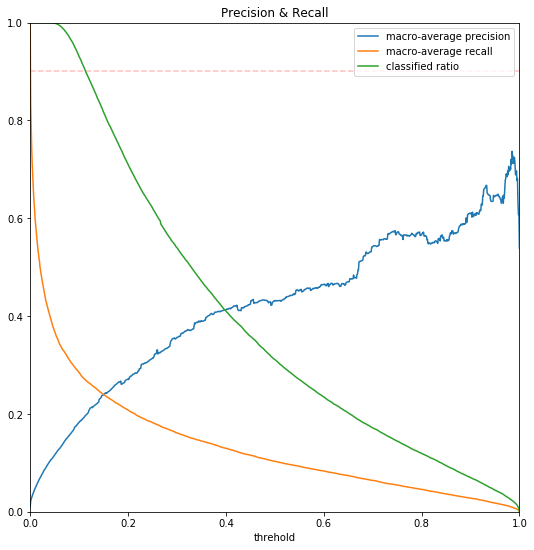

In [19]:
plt.figure(figsize=(9,9))

plt.axhline(0.9, color="red",linestyle='dashed', alpha=0.25)
plt.plot(thresholds, averagePrecision, label="macro-average precision")
plt.plot(thresholds, averageRecall, label="macro-average recall")
plt.plot(thresholds, classifiedProportion, label="classified ratio")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="upper right")
plt.xlabel("threhold")
plt.title("Precision & Recall")

In [18]:
threshold90 = thresholds[averagePrecision >= 0.9].min()
recall90 = averageRecall[threshold90 == thresholds][0]
print("To reach a multiclass average precision more than 90%, the minimum threshold is " + str(threshold90) + "; the corresponding multiclass average recall is " + str(recall90) + ". ")

ValueError: zero-size array to reduction operation minimum which has no identity